<a href="https://colab.research.google.com/github/blinov-89/MPTI/blob/main/MPTI_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
import os
from sklearn.model_selection import train_test_split
import json
from math import sin, cos

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Датасет


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
json_dir = "/content/drive/MyDrive/Всероссийский ИИ/MPTI/train/json/"

data_df = pd.DataFrame({'id': [], "left_top_x": [], 'left_top_y': [], "right_bottom_x": [], 'right_bottom_y': [], 'angle': []})

json_true = []
for _, _, files in os.walk(json_dir):
    for x in files:
        if x.endswith(".json"):
            data = json.load(open(json_dir + x))
            new_row = {'id':x.split(".")[0]+".png", 'left_top_x':data["left_top"][0], 'left_top_y':data["left_top"][1], 'right_bottom_x': data["right_bottom"][0], "right_bottom_y": data["right_bottom"][1], 'angle': data["angle"]}
            data_df = data_df.append(new_row, ignore_index=True)


In [4]:
data_df.head(5)

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,angle
0,1.png,8533.0,2184.0,9834.0,2819.0,341.0
1,100.png,7078.0,4789.0,7597.0,3438.0,246.0
2,1065.png,6983.0,3251.0,8212.0,2484.0,283.0
3,1079.png,6934.0,8975.0,7958.0,9999.0,0.0
4,1054.png,5819.0,8095.0,5324.0,9456.0,65.0


In [5]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['left_top_x']/10496, 
        self.data_df.iloc[idx]['left_top_y']/10496, self.data_df.iloc[idx]['right_bottom_x']/10496, 
        self.data_df.iloc[idx]['right_bottom_y']/10496, self.data_df.iloc[idx]['angle']/360]

        # читаем картинку. read the image
        image = cv2.imread(f"/content/drive/MyDrive/Всероссийский ИИ/MPTI/train/img/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels).float()
        # .long()
    
    def __len__(self):
        return len(self.data_df)

In [6]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [7]:
from os import listdir

print("Обучающей выборки " ,len(listdir("/content/drive/MyDrive/Всероссийский ИИ/MPTI/train/img/")))
print("Тестовой выборки " ,len(listdir("/content/drive/MyDrive/Всероссийский ИИ/MPTI/test_dataset_test/")))

Обучающей выборки  812
Тестовой выборки  400


In [8]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.3, random_state=42)

In [9]:
train_df.shape, valid_df.shape

((560, 6), (240, 6))

In [10]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                           )

In [12]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [13]:
images.shape

torch.Size([16, 3, 224, 224])

In [14]:
labels.shape

torch.Size([16, 5])

# Вспомогательные функции

In [15]:
def compute_metric(data_true, data_pred, outImageW = 10496, outImageH = 10496):

    x_center_true = np.array((data_true[0] + data_true[2])/2).astype(int)
    y_center_true = np.array((data_true[1] + data_true[3])/2).astype(int)

    x_metr = x_center_true - np.array((data_pred[0] + data_pred[2])/2).astype(int)
    y_metr = y_center_true - np.array((data_pred[1] + data_pred[3])/2).astype(int)

    metr =  1 - 0.7 * (abs(x_metr)/outImageH + abs(y_metr)/outImageW)/2 + 0.3 *abs(data_pred[4] - data_true[4])/359
    return metr

In [16]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [17]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = []

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append((loss.data.cpu().detach().numpy() / y_pred.size(0)) * 100)
            
            y_pred[:, :4] = y_pred[:, :4] * 10496
            y_pred[:, -1] = y_pred[:, -1] * 360

            labels[:, :4] = labels[:, :4] * 10496
            labels[:, -1] = labels[:, -1] * 360

            for label, pr in zip(labels, y_pred):
                    train_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

            optimizer.step()

        train_acc_log.append(train_pred)

        val_loss = 0.
        val_size = 0
        
        val_pred = []
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)

                pred[:, :4] = pred[:, :4] * 10496
                pred[:, -1] = pred[:, -1] * 360

                labels[:, :4] = labels[:, :4] * 10496
                labels[:, -1] = labels[:, -1] * 360
                
                val_loss += loss.item()
                val_size += pred.size(0)

                for label, pr in zip(labels, pred):
                    val_pred.append(compute_metric(label.cpu().detach().numpy(), pr.cpu().detach().numpy()))

        val_loss_log.append((val_loss / val_size)*100)
        val_acc_log.append(val_pred)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train metric:', (np.mean(train_pred)))
        print('Val metric:', (np.mean(val_pred)))
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

# Модель

In [18]:
torch.cuda.empty_cache()

In [19]:
# Подргружаем модель

model = models.regnet_x_32gf(pretrained=True)
model.fc = nn.Linear(2520, 5)

model = model.cuda()
criterion = torch.nn.MSELoss()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=RegNet_X_32GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_32GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_x_32gf-9d47f8d0.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_32gf-9d47f8d0.pth


  0%|          | 0.00/412M [00:00<?, ?B/s]

In [20]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

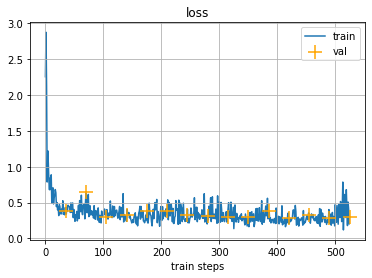

100%|██████████| 15/15 [12:29<00:00, 49.95s/it]

Train loss: 0.3506249319096761
Val loss: 0.30304780695587397
Train metric: 0.9633898342332693
Val metric: 0.9767583270856598


In [21]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 valid_loader, 
                                                                 15)

## Посчитаем метрику

In [22]:
total_metric = []

for imgs, labels in valid_loader:
    imgs = imgs.cuda()
    labels = labels.cpu().detach().numpy()            
    pred = model(imgs)
    pred = pred.cpu().detach().numpy()    

    pred[:, :4] = pred[:, :4] * 10496
    pred[:, -1] = pred[:, -1] * 360

    labels[:, :4] = labels[:, :4] * 10496
    labels[:, -1] = labels[:, -1] * 360
    
    for label, pr in zip(labels, pred):
        total_metric.append(compute_metric(label, pr))
    
total_metric = np.mean(total_metric)
print('Total metric:', total_metric)

Total metric: 0.9775043706479034


# Создадим предсказания на тестовом наборе данных

In [23]:
model.eval()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 336, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 336, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(336, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(336, 336, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [24]:
class TestImageDataset(Dataset):
    def __init__(self, files, transform=None):

        self.files = files
        self.transform = transform

    def __getitem__(self, idx):

        image_name = self.files[idx]

        # читаем картинку. read the image
        image = cv2.imread(f"/content/drive/MyDrive/Всероссийский ИИ/MPTI/test_dataset_test/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно. transform it, if necessary
        if self.transform:
            image = self.transform(image)
        
        return image
        # .long()
    
    def __len__(self):
        return len(self.files)

In [25]:
test_images_dir = '/content/drive/MyDrive/Всероссийский ИИ/MPTI/test_dataset_test/'

for _, _, test_files in os.walk(test_images_dir):
    break

test_dataset = TestImageDataset(test_files, valid_transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=16,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2
                                           )

In [26]:
indexes = [x.split('.')[0] for x in test_files]
preds = []

for imgs in test_loader:
    imgs = imgs.cuda()            
    pred = model(imgs)
    pred = pred.cpu().detach().numpy()
    pred[:, :4] = np.clip(pred[:, :4] * 10496, 0, 10496)
    pred[:, -1] = np.clip(pred[:, -1] * 360, 0, 360)
    preds.extend(list(pred))

In [27]:
sub_dir = "/content/drive/MyDrive/Всероссийский ИИ/MPTI/submission/"
if not os.path.exists(sub_dir):
    os.makedirs(sub_dir)

json_true = []

for indx, pred in zip(indexes, preds):

    pred = [int(x) for x in pred]

    left_top = [pred[0], pred[1]]
    right_top = [pred[2], pred[1]]
    left_bottom = [pred[0], pred[3]]
    right_bottom = [pred[2], pred[3]]
        
    res = {
        'left_top': left_top,
        'right_top': right_top,
        'left_bottom': left_bottom,
        'right_bottom': right_bottom,
        'angle': pred[4]
    }

    with open(sub_dir+indx+'.json', 'w') as f:
        json.dump(res, f)


In [28]:
from glob import glob

In [29]:
len(glob('/content/drive/MyDrive/Всероссийский ИИ/MPTI/submission/*'))

400